In [1]:
import numpy as np
from matplotlib import pyplot as plt
import numba as nb
from scipy import interpolate
from scipy.integrate import solve_ivp
from scipy.optimize import root

import pickle
import yaml

from ImpactAtmosphere import SteamAtm

# Impactor size, and the fate of iron

[Citron and Stewart (2022)](https://arxiv.org/abs/2201.09349) computed the fate of Iron after big impacts on the Early Earth. We can parameterize their results in their Table C.3. The problem is that they only compute the fate of Iron after impactors larger than $7.6\times10^{24}$ grams, but we need to know what happens for $2.3\times10^{23}$ gram impactors (Vesta-sized). Here we will linearly extrapolate their results down to smaller impacts.

We only consider their results for a $\theta = 45\deg$, and $\frac{v_{imp}}{v_{esc}} = 1.5$, because these are the most likely parameters.

We assume that the avaliable iron in the surface region is the iron that does end up in the interior of the planet, or that is ejected to space. So `X_avail = X_surf + X_atmo + X_disk`.

X_avail_extrapolate = 0.07059343603482922


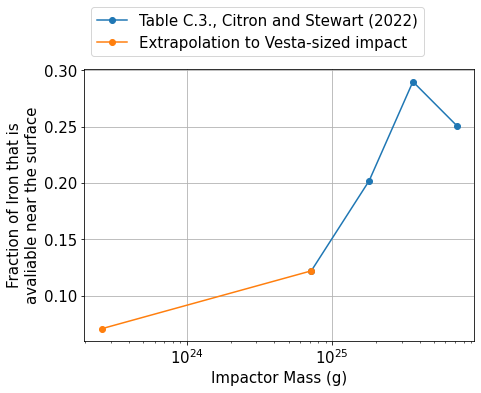

In [2]:
Me = 5.972e27 # mass of Earth (g)

# Citron and Stewart (2022)
# Table C.3.
# vimp/vesc = 1.5
# Theta = 45 degrees
Mi = Me*np.array([0.0012, 0.003, 0.006, 0.012])
X_surf = np.array([0.030, 0.024, 0.032, 0.015])
X_atmo = np.array([0.091, 0.174, 0.240, 0.212])
X_disk = np.array([0.001, 0.004, 0.018, 0.024])
X_avail = X_surf + X_atmo + X_disk

# Linearly extrapolate down to a vesta impactor
M_vesta = 2.589e23
f = interpolate.interp1d(Mi, X_avail, fill_value='extrapolate')
X_avail_extrapolate = f(M_vesta).item()
print("X_avail_extrapolate =",X_avail_extrapolate)

# plot extrapolation
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])
fig.patch.set_facecolor("w")

ax.plot(Mi,X_avail,'o-',label='Table C.3., Citron and Stewart (2022)')
ax.plot([M_vesta, Mi[0]],[X_avail_extrapolate, X_avail[0]],'o-',label='Extrapolation to Vesta-sized impact')

ax.legend(ncol=1,bbox_to_anchor=(0,1.02),loc='lower left')
ax.set_xscale('log')
ax.set_ylabel('Fraction of Iron that is\navaliable near the surface')
ax.set_xlabel('Impactor Mass (g)')
ax.grid()

plt.savefig('figures/Citron_Steward_Extrapolation_to_Vesta.pdf',bbox_inches='tight')

plt.show()

# Simulating Post-Impact Atmosphere

We use [ImpactAtmosphere v4.2.7](https://github.com/Nicholaswogan/ImpactAtmosphere/tree/2528c64c101bbde56db1886c6b59ca3df7cd05f0) to simulate that atmosphere after an impact:

In [3]:
def simulate_impact(Fe_frac_atmos, Fe_react_frac):
    N_H2O_ocean = 15.0e3 # moles/cm2 (15e3 is 1 ocean)
    N_CO2 = 23.  # moles/cm2 (23 is "one bar" of CO2)
    N_N2  = 36. # moles/cm2 (36 is "one bar" of N2)

    stm = SteamAtm('zahnle_earth.yaml')
    stm.Fe_react_frac = Fe_react_frac
    stm.Fe_frac_atmos = Fe_frac_atmos
    sol = stm.impact(N_H2O_ocean,N_CO2,N_N2,M_vesta)
    sol['Psurf'] = sol['Psurf']*np.ones(len(sol['time']))
    return sol

In [4]:
# here we assume that half the iron reacts with atmosphere, 
# and the other half can react with fatty acids
sol = simulate_impact(0.5, X_avail_extrapolate)

Integration successful.                 


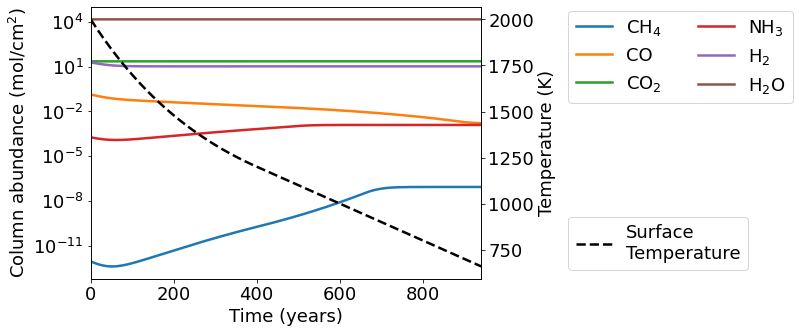

In [5]:
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(1,1,figsize=[7,5])

yr = 365*24*60*60
species = ['CH4','CO','CO2','NH3','H2','H2O']
labels = ['CH$_4$','CO','CO$_2$','NH$_3$','H$_2$','H$_2$O']
for i,spec in enumerate(species):
    ax.plot(sol['time']/yr,sol[spec]*sol['Ntot'],'C'+str(i)+'-',lw=2.5,label=labels[i])
ax.set_yscale('log')
ax.legend(ncol=2,bbox_to_anchor=(1.2,1.02),loc='upper left')
ax1 = ax.twinx()

ax1.plot(sol['time']/yr,sol['Tsurf'],'k--',lw=2.5,label='Surface\nTemperature')

ax1.legend(ncol=1,bbox_to_anchor=(1.2,0),loc='lower left')
ax.set_ylabel('Column abundance (mol/cm$^2$)')
ax.set_xlabel('Time (years)')
ax1.set_ylabel('Temperature (K)')

ax.set_xlim(0,sol['time'][-1]/yr)

plt.show()

# Modeling the Steam Condensation

`ImpactAtmosphere`, used above, does not model the period of time when the Ocean is condensing. This is because it is un-important for the chemical composition after the steam condenses. But for this project, we want to know the Temperature vs time during the condensation phase. We will assume that chemistry does not change (only H2O condenses).

I worked out an ordinary differential equation which estimates the Temperture vs. time for a condensing ocean. The fundamental equation is 

$$
\frac{\partial T}{\partial t} = \frac{1}{\rho c_p} \frac{\partial F}{\partial z} - \frac{L}{A_e}\frac{\partial m_\mathrm{H_2O}}{\partial t}
$$

A description of each variable is in the table below. This equation says that the tempeture changes because of radiation of energy to space (the first term), and energy gained from latent heat of condensation (second term).

| Variable          | Description                       | Units                          |
| ----------------- | --------------------------------- | ------------------------------ |
| $T$               | Temperature                       | K                              |
| $t$               | Time                              | s                              |
| $\rho$            | Density of the atmosphere         | $\mathrm{\frac{g}{cm^3}}$      |
| $c_p$             | Specific heat capacity of water   | $\mathrm{\frac{ergs}{g K}}$    |
| $F$               | Radiative flux                    | $\mathrm{\frac{ergs}{cm^2 s}}$ |
| $z$               | Altitude                          | cm                             |
| $L$               | Latent heat of water vaporization | $\mathrm{\frac{ergs}{g}}$      |
| $A_e$             | Area of Earth                     | $\mathrm{cm^2}$                |
| $m_\mathrm{H_2O}$ | Mass of H2O in the atmosphere     | g                              |
|                   |                                   |                                |

In the code below, I have re-worked the equation above, so it can be solved over time easily.

In [6]:
def make_functions():
    cp = 1996e4 # ergs/(g*K)
    LL = 2.5e10 # ergs/g
    Fir = 1.6e5 # ergs/cm2/s
    g = 981 # cm/s2
    
    # parameters for H2O satuation vapor pressure
    AA = 3.88e11 
    TB = 4800

    @nb.njit
    def sat_pressure_H2O(T):
        # output is dynes/cm2
        return AA*np.exp(-TB/T)

    @nb.njit
    def dT_dt(t,y):
        T = y[0]
        P = sat_pressure_H2O(T)
        return -(g/(cp*P))*Fir*(1+(LL/cp)*(TB/T**2))**-1
    
    def stop_event(t,y):
        # we stop at 200 C.
        return y[0]-473
    stop_event.terminal = True

    return dT_dt, sat_pressure_H2O, stop_event

def obj(x, PH2O):
    T = x[0]
    return PH2O - sat_pressure_H2O(T)/1e6
    
def PT_vs_time(Tsurf0):
    sol1 = solve_ivp(dT_dt, [0,np.inf], np.array([Tsurf0]), method='LSODA', events=stop_event, rtol=1e-9)
    T = sol1.y[0,:]
    P = sat_pressure_H2O(T)/1e6
    return T, P, sol1.t

def gen_whole_solution(T, P, time, sol):
    nt = len(time)
    # relevant mixing ratios
    PH2 = sol['H2'][-1]*sol['Psurf'][-1]*np.ones(nt)
    if PH2[0] > P[-1]*.1:
        raise Exception("Assumption of constant mixing ratios is bad!")
    PCO = sol['CO'][-1]*sol['Psurf'][-1]*np.ones(nt)
    PCH4 = sol['CH4'][-1]*sol['Psurf'][-1]*np.ones(nt)

    time = time + sol['time'][-1]

    # put together output
    s = {}
    s['time'] = np.append(sol['time'],time)
    s['Tsurf'] = np.append(sol['Tsurf'],T)
    s['Psurf'] = np.append(sol['Psurf'],P+PH2+PCO+PCH4)
    s['PH2O'] = np.append(sol['H2O']*sol['Psurf'],P)
    s['PH2'] = np.append(sol['H2']*sol['Psurf'],PH2)
    s['PCO'] = np.append(sol['CO']*sol['Psurf'],PCO)
    s['PCH4'] = np.append(sol['CH4']*sol['Psurf'],PCH4)
    return s

def do_condensing_phase(sol):
    T_start = root(obj,sol['Tsurf'][-1],args=(sol['H2O'][-1]*sol['Psurf'][-1],)).x[0]
    T, P, time = PT_vs_time(T_start)
    s = gen_whole_solution(T, P, time, sol)
    return s

In [7]:
# actually do calculations
dT_dt, sat_pressure_H2O, stop_event = make_functions()
s = do_condensing_phase(sol)

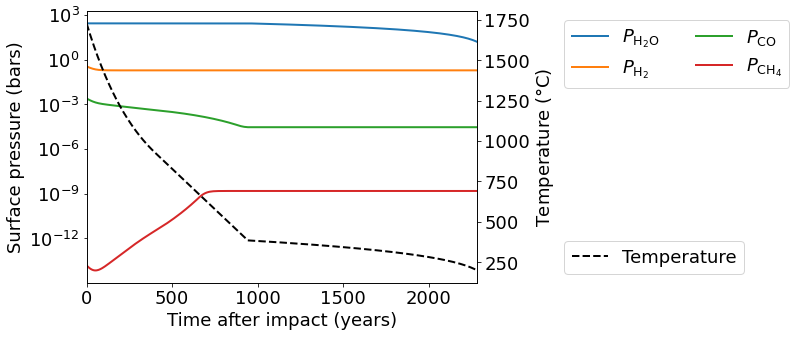

In [8]:
# plot results
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(1,1,figsize=[7,5])

yr = 365*24*60*60

ax.plot(s['time']/yr,s['PH2O'],lw=2,label='$P_\mathrm{H_2O}$')
ax.plot(s['time']/yr,s['PH2'],lw=2,label='$P_\mathrm{H_2}$')
ax.plot(s['time']/yr,s['PCO'],lw=2,label='$P_\mathrm{CO}$')
ax.plot(s['time']/yr,s['PCH4'],lw=2,label='$P_\mathrm{CH_4}$')

ax1 = ax.twinx()

ax1.plot(s['time']/yr,s['Tsurf']-273,'k--',lw=2,label='Temperature')

ax1.set_ylabel('Temperature ($\degree$C)')
ax.set_ylabel('Surface pressure (bars)')
ax.set_xlabel('Time after impact (years)')
ax.set_xlim(0,s['time'][-1]/yr)
ax.set_yscale('log')

ax.legend(ncol=2,bbox_to_anchor=(1.2,1.0),loc='upper left')
ax1.legend(ncol=1,bbox_to_anchor=(1.2,0.0),loc='lower left')

plt.savefig('figures/Nominal_Vesta_0.5.pdf',bbox_inches='tight')

plt.show()

# Considering bigger parameter space

We want to consider different values of `Fe_frac_atmos`, this is the fraction of iron avaliable in the surface environment that reacts with the ocean and atmosphere. We assume the remaining iron is used for fatty acid synthesis.

We will take `Fe_react_frac` to be constant at ~0.07, based on our extrapolation from Citron and Stewart (2022).

In [9]:
Fe_frac_atmos_ = [0.01, 0.1, 0.5, 0.9, 1.0]
res = {}
for Fe_frac_atmos in Fe_frac_atmos_:
    sol = simulate_impact(Fe_frac_atmos, X_avail_extrapolate)
    s = do_condensing_phase(sol)
    res[Fe_frac_atmos] = s

Integration successful.                 
Integration successful.                 
Integration successful.                 
Integration successful.                 
Integration successful.                 


In [10]:
# save the results

# meta data
meta = {}
meta['mass-impactor-grams'] = M_vesta
meta['preimpact-oceans'] = 1
meta['preimpact-CO2-bars'] = 1
meta['preimpact-N2-bars'] = 1
meta['Fe-react-fract'] = X_avail_extrapolate

f = open('results/impact_simulations_metadata.yaml','w')
yaml.dump(meta,f,Dumper=yaml.Dumper)
f.close()

f = open('results/impact_simulations.pkl','wb')
pickle.dump(res,f)
f.close()

In [2]:
# Results can be opened with
def load_results(f1, f2):
    f = open(f1,'r')
    meta = yaml.load(f,Loader=yaml.Loader)
    f.close()

    f = open(f2,'rb')
    s = pickle.load(f)
    f.close()
    
    return meta, s

In [3]:
meta, res = load_results('results/impact_simulations_metadata.yaml', 'results/impact_simulations.pkl')

In [7]:
# also save data cvs
sims = list(res.keys())
fmt = "{:20}"

labels = ['time (s)', 'Tsurf (K)', 'Psurf (bar)', 'PH2O (bar)', 'PH2 (bar)', 'PCO (bar)', 'PCH4 (bar)']

for sim in sims:
    f = open('results/'+str(sim)+'.csv','w')
    
    nk = len(res[sim].keys())
    for i,key in enumerate(res[sim].keys()):
        if i < nk-1:
            f.write(fmt.format(labels[i]+','))
        else:
            f.write(fmt.format(labels[i]))
    
    f.write('\n')
    
    for i in range(len(res[sim]['time'])):
        for j,key in enumerate(res[sim].keys()):
            tmp = '%e'%res[sim][key][i]
            if j < nk-1:
                f.write(fmt.format(tmp+','))
            else:
                f.write(fmt.format(tmp))
        f.write('\n')
    
    
    f.close()
